# [Ravi Raghavan]
# Netflix Stock Prices Notebook
---

# Preamble

In [1661]:
# import relevant Python libraries
import numpy as np  #import numpy 
import pandas as pd #import pandas
from scipy import stats as sps  #import stats from scipy
from matplotlib import pyplot as plt    #import pyplot from matplotlib
from mpl_toolkits.mplot3d import Axes3D #import Axes3D from mpl_toolkits.mplot3d
from IPython.display import display, Latex  #import display and Latex from IPython.display
import seaborn as sns
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mticker
import matplotlib.dates as mdates



### Your import commands go here ###

# **1. Brief Exploration of Dataset**

In [1662]:
netflix_stock_prices = pd.read_csv("NFLX.csv") #read in netflix stock prices into pandas dataframe 
print(netflix_stock_prices.head(10)) #display first two rows of dataframe just to get a feel for what the dataframe contains 

         Date        Open        High         Low       Close   Adj Close  \
0  2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1  2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2  2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3  2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4  2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   
5  2018-02-12  252.139999  259.149994  249.000000  257.950012  257.950012   
6  2018-02-13  257.290009  261.410004  254.699997  258.269989  258.269989   
7  2018-02-14  260.470001  269.880005  260.329987  266.000000  266.000000   
8  2018-02-15  270.029999  280.500000  267.630005  280.269989  280.269989   
9  2018-02-16  278.730011  281.959991  275.690002  278.519989  278.519989   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  
5   8534900  
6   6855200  
7  10972000  
8  10759700  
9   8312400 

_[The first code cell here is to simply load the netflix stock prices data into a pandas dataframe. Then, I will print the dataframe just to get a feel for what the dataframe contains. ]_

In [1663]:
n, p = netflix_stock_prices.shape #get shape of dataframe(n: number of rows, p: number of columns)
print(f"Number of Rows in Dataframe: {n}") #print number of rows
print(f"Number of Columns in dataframe: {p}") #print total number of columns in dataframe

Number of Rows in Dataframe: 1009
Number of Columns in dataframe: 7


_[To briefly explore this dataset, the first thing I wanted to do was first calculate the total number of rows in my dataframe and the total number of columns in my dataframe. There are a total of 1009 rows in this dataframe. This means that the dataframe contains data across 1009 different days that the value of the Netflix Stock was measured. There are 7 rows in this dataframe. The first column is "Date" which indicates the date that data was gathered about the Netflix Stock. The second column is "Open" which represents the price at which stock opened. The third column is "High" which represents the peak price of the Netflix Stock for that particular day. The fourth column is "Low" which represents the low price of the Netflix Stock for that particular day. The fifth column is "Close" which represents the closing price of the Netflix Stock for that particular day. The sixth column is "Adjusted Close" which represents the adjusted closed price adjusted for splits, dividends, and capital gains distributions. Finally, the seventh column is "Volume" which represents the volume of Netflix Stock for that particular day. ]_

In [1664]:
valuesMissing = netflix_stock_prices.isna().sum().sum() #Compute total number of Cells with Missing Values
print(f"Number of missing values: {valuesMissing}")

Number of missing values: 0


_[The next step is to calculate the number of cells with missing values(i.e. empty cells). Luckily, our dataset has 0 missing values]_

The column Date can not be represented as a histogram


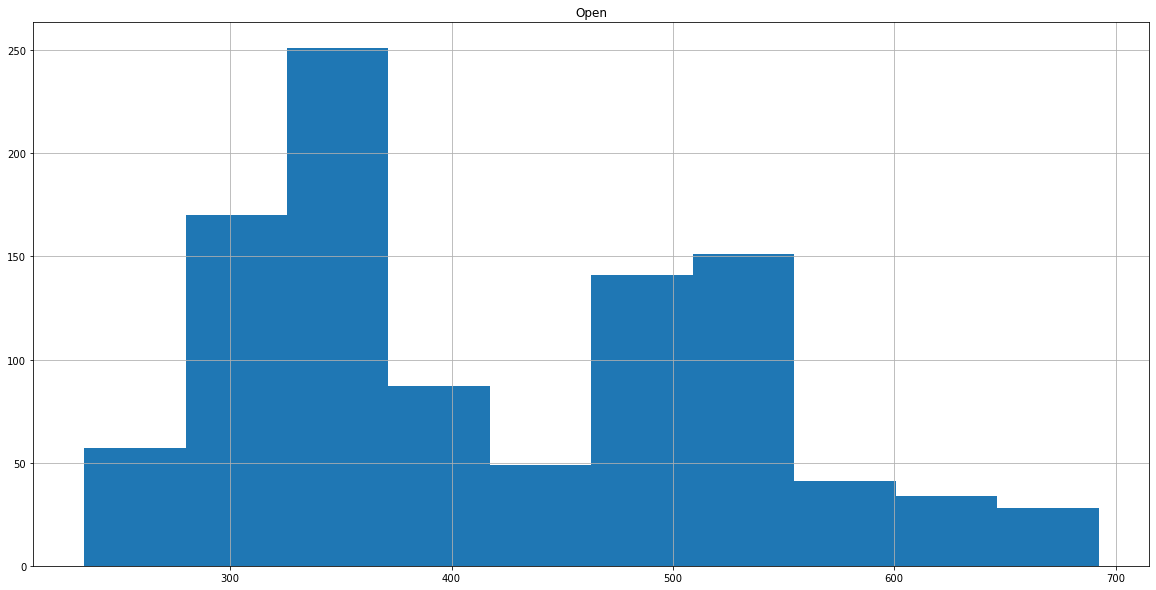

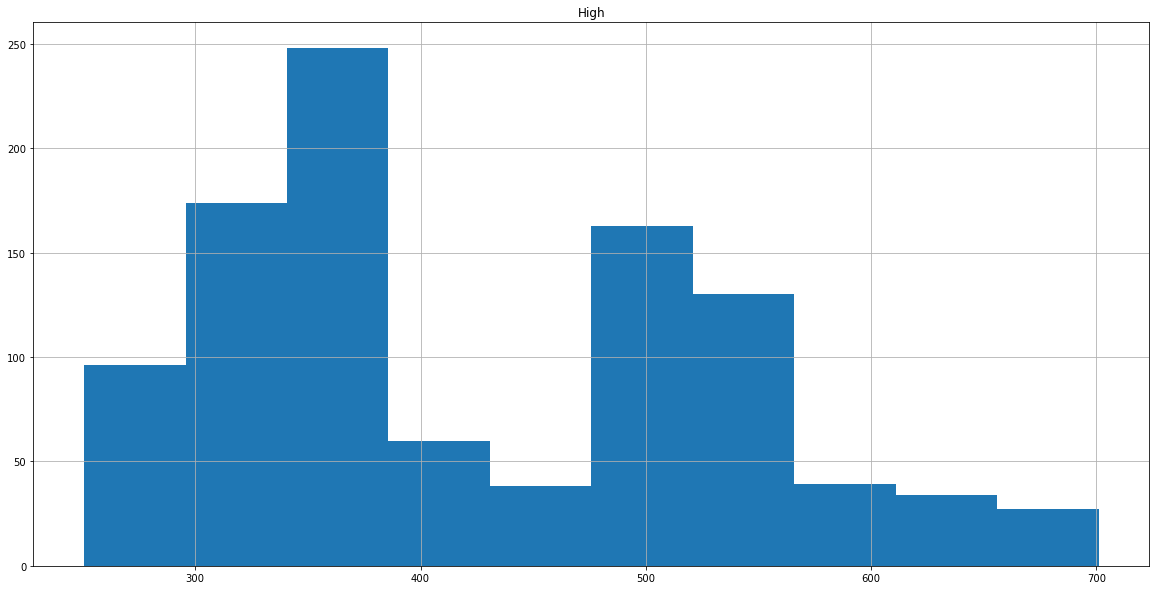

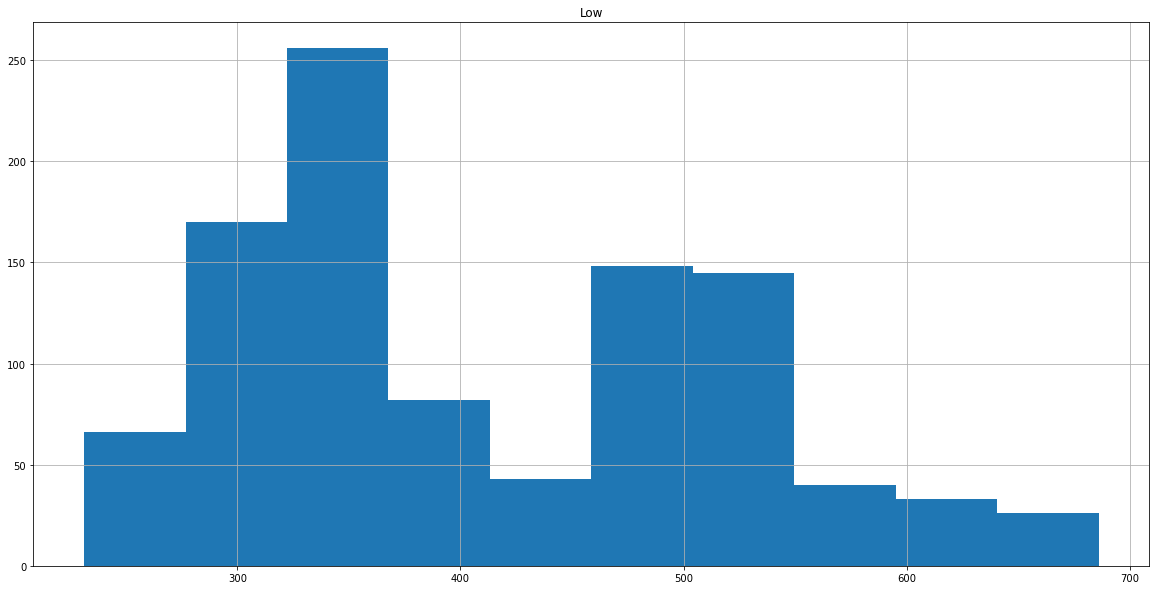

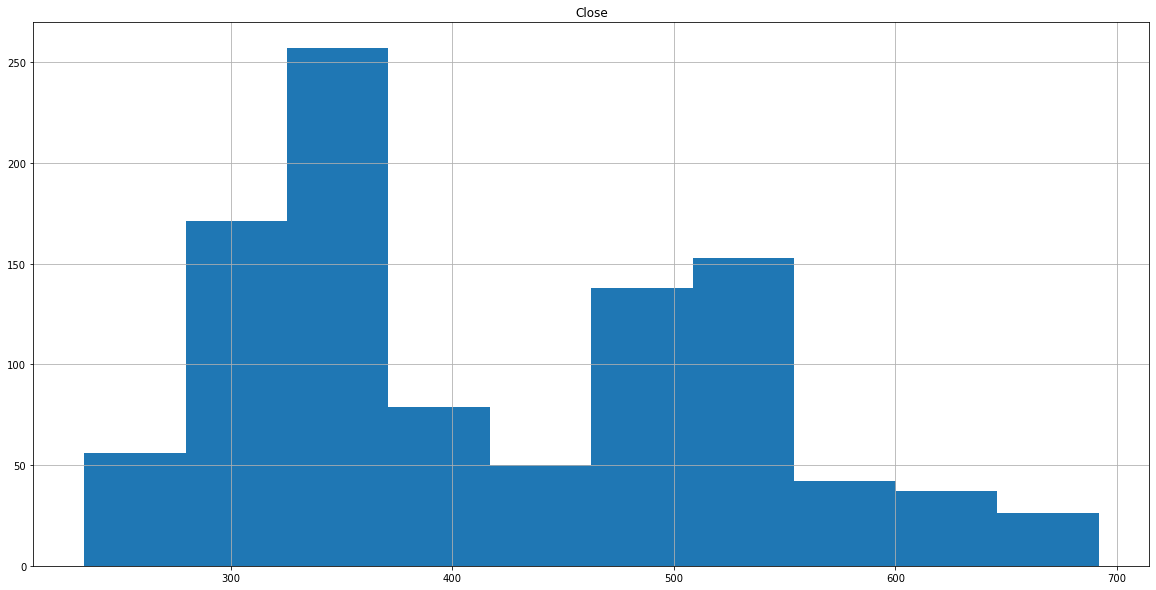

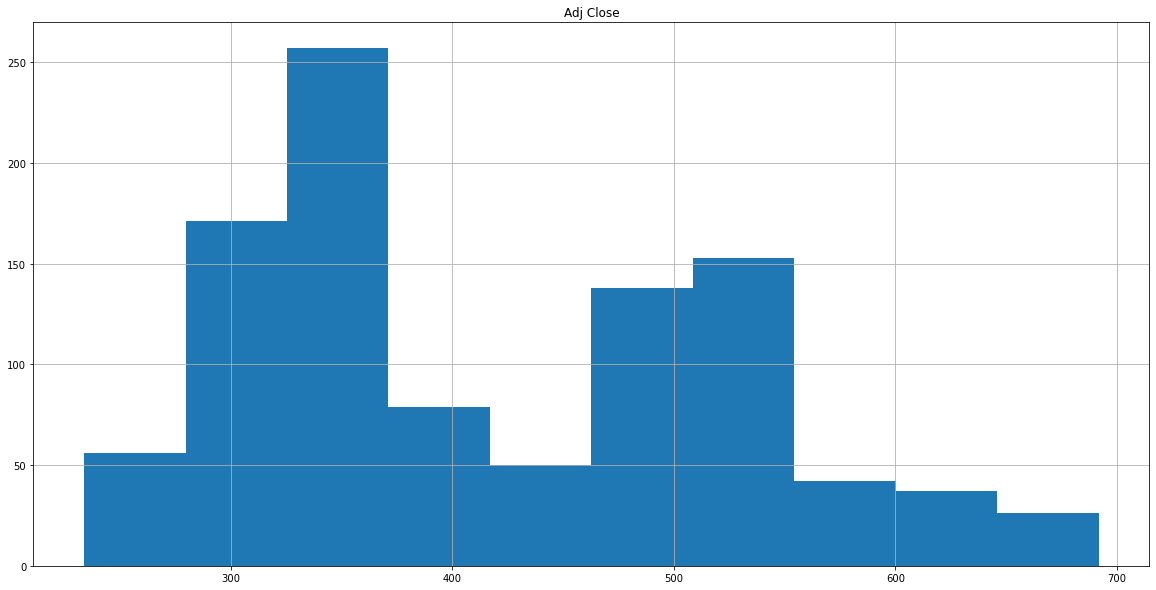

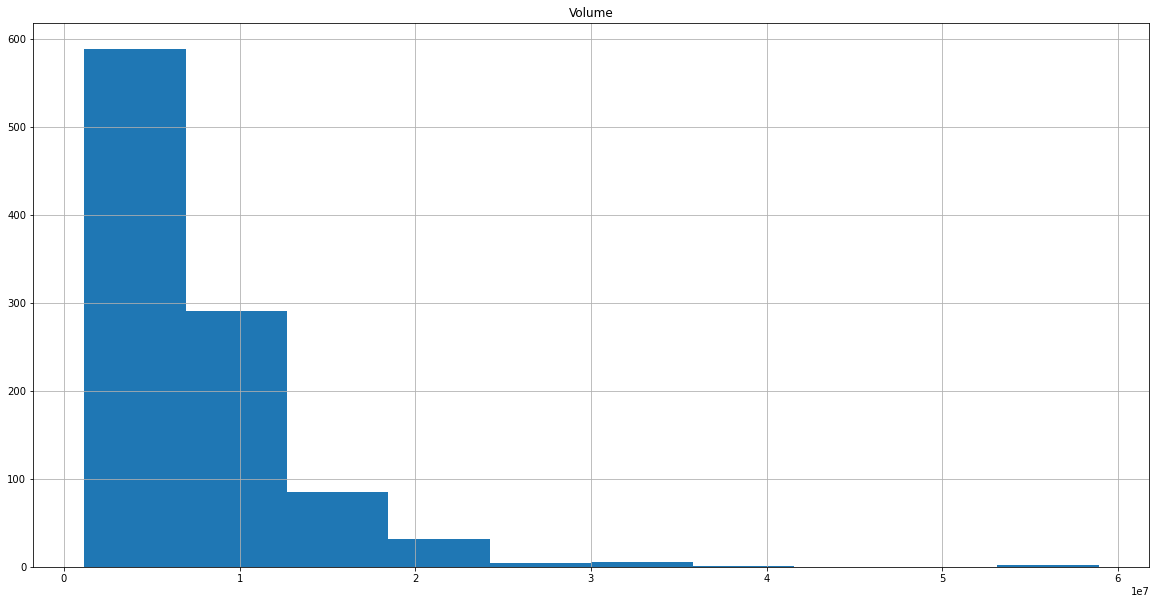

In [1665]:
for column in netflix_stock_prices.columns:
    try:      
        netflix_stock_prices[column] = pd.to_numeric(netflix_stock_prices[column]) 
        netflix_stock_prices.hist(column)
    except ValueError:
        print(f"The column {column} can not be represented as a histogram")

_[The second part of this brief data exploration is to figure out which features are categorical. The reason I need to do this is so that I can figure out which features to one-hot encode during the next phase(i.e. when we are preprocessing the data). This part of the analysis clearly shows that the features Open, High, Low, Close, Adj. Close, and Volume are not categorical variables because they don't take on a finite set of values. They can take on an infinite range of values. Hence, by definition, they cannot be considered categorical. The "Date" column is not really considered a variable here for the sake of analysis because its more so used to identify each data sample. Hence, I am not really considering it as a "variable" for analysis. Hence, given the aforementioned statements, it is clear that there are no categorical variables. ]_

Text(0.5, 1.0, 'Netflix Inc.')

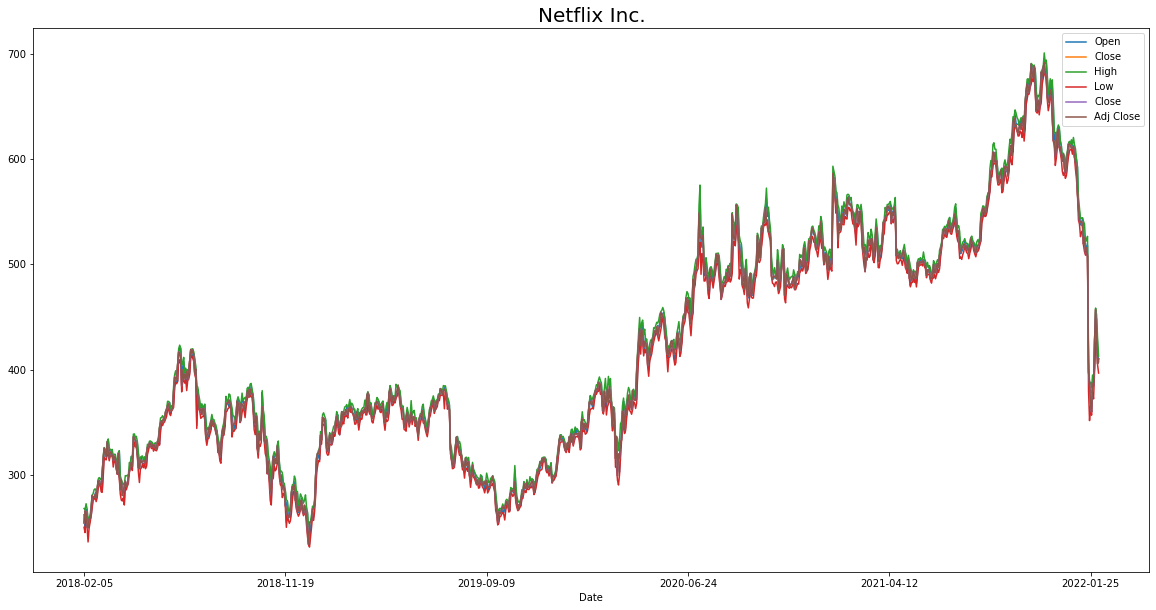

In [1666]:
netflix_stock_prices.set_index("Date", inplace = True) #set date as the index
netflix_stock_prices[['Open', 'Close', 'High','Low','Close','Adj Close']].plot(figsize= (20, 10)) #Plot Stock Values for Netflix Over period from Feb 2018 to Feb 2022
plt.title("Netflix Inc.", fontsize = 20) #Title the Plot Netflix Inc. 

_[Since the Date variable is used to identify each data sample, I set the index of this dataframe to be the "Date" variable. I plotted the Open, Close, High, Low, Adj.Close on a graph to see the trends in Netflix Stock Price from Feb 2018 to Feb 2022. Clearly, we can see a general upwards trend over the past 5 years but quite few short-term fluctuations in the stock price]_

# **2. Pre-processing of Dataset**

In [1667]:
def is_logical(feature, value):
    if (value == np.nan or value == None):
        return False
    if (feature != "Volume"):
        return value >= 125 and value <= 750
    return value >= 1000000 and value <= 60000000 

count = 0
for column in netflix_stock_prices:
    columnSeries = netflix_stock_prices[column] #retrieve column from data frame
    li = [] #list to store newly created column
    
    #Go through all values in the column. If the value is logically consistent, append this value to the list
    #If the value is not logically consistent, append NaN to the list
    for value in columnSeries:
        if (is_logical(column, value)):
            li.append(value)
        else:
            li.append(np.nan)
            count = count + 1
    
    #Convert li to pandas Series and store this in the column
    if (np.nan in li):
        netflix_stock_prices[column] = pd.Series(li)   

netflix_stock_prices.interpolate(inplace = True) #fill in NaN values via interpolation



_[After looking up the Netflix Stock Prices from Feb 2018 to Feb 2022, the lowest the stock price ever got to was roughly 175 and the highest it ever got to was 700. Hence, to set a reasonable buffer, I made the lower bound for price 125 and the higher bound 750. For volume, the lowest volume for stock prices from Feb 2018 to Feb 2022 was roughly 1.7 million and the highest was around 50 million. Hence, for a reasonable buffer, I set the lower bound for volume to be 1 million and the upper bound to be 60 million. Once I wrote the function to determine whether a value for particular feature is logically valid, I went through the dataframe to validate each and every value. Invalid values were simply repalced with NaN. After I finished validating values, I replaced any NaN values via simple interpolation. Essentially if there were NaN values between non-NaN values, the function interpolate() draws a line between the NaN values and replaces the NaN values with values on this line.  ]_

# **3. Feature Engineering / Feature Learning**

In [1668]:
netflix_stock_prices["Moving Average"] = netflix_stock_prices["Adj Close"].rolling(window= 14, closed = "left").mean()
netflix_stock_prices["Standard Deviation"] = netflix_stock_prices["Adj Close"].rolling(window= 14, closed = "left").std()
netflix_stock_prices["Moving Maximum"] = netflix_stock_prices["Adj Close"].rolling(window= 14, closed = "left").max()
netflix_stock_prices["Moving Minimum"] = netflix_stock_prices["Adj Close"].rolling(window= 14, closed = "left").min()

X = netflix_stock_prices[["Moving Average", "Standard Deviation", "Moving Maximum", "Moving Minimum"]].to_numpy()
X = X[14: ]
Y = netflix_stock_prices[["Adj Close"]].to_numpy()
Y = Y[14: ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=104, test_size=0.20, shuffle=True) #split data into train/test

datascaler = sklpp.StandardScaler()
# use the fit_transform API to simultaneously compute mean and center data
X_train = datascaler.fit_transform(X_train)
X_test = datascaler.transform(X_test)

pca = skldecomp.PCA(n_components = 0.90, svd_solver = 'full')  #solve PCA problem to capture at least 90% energy
X_train = pca.inverse_transform(pca.fit_transform(X_train))
X_test = pca.inverse_transform(pca.transform(X_test))



# **4. Processing The Dataset Via Machine Learning**

In [1669]:
model1 = LinearRegression().fit(X_train, Y_train)

# **5. Comparative Analysis**

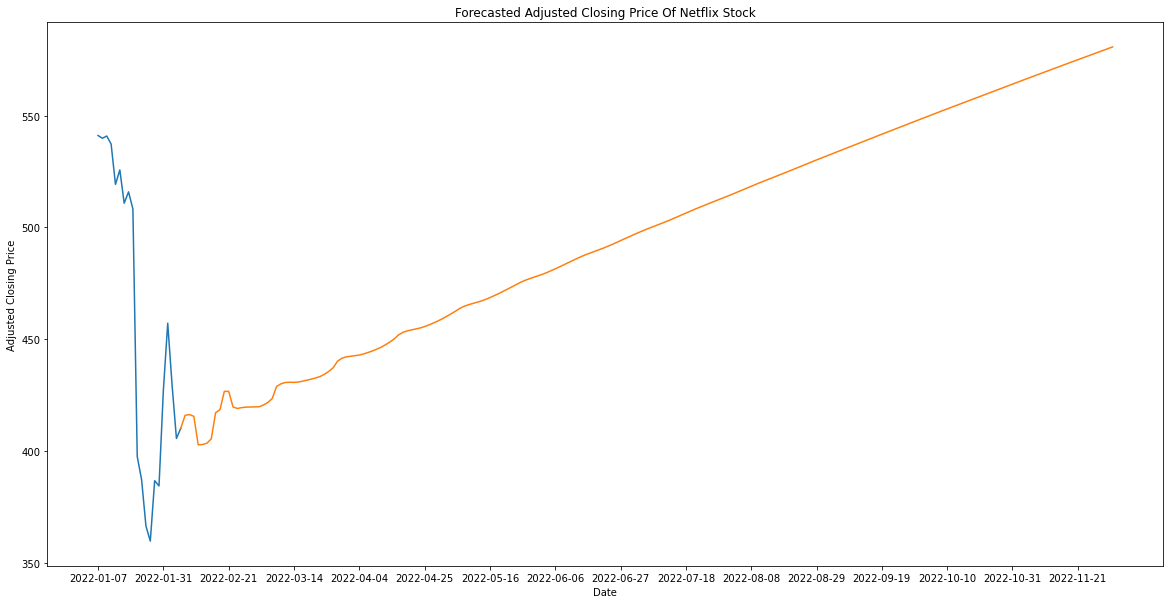

In [1670]:
N, P = X_test.shape
prediction = model1.predict(X_test)
error = sum([((actual_label - predicted_label) / actual_label) ** 2 for predicted_label, actual_label in zip(prediction, Y_test)]) / N

data_size = netflix_stock_prices.shape
num_rows = 214
previous_two_weeks = Y[-14: ]
feature_array = np.zeros((1, 4))
forecasts = np.zeros((num_rows + 1, 1))

for day in range(num_rows):
    feature_array[0][0] = np.mean(previous_two_weeks)
    feature_array[0][1] = np.std(previous_two_weeks)
    feature_array[0][2] = np.amax(previous_two_weeks)
    feature_array[0][3] = np.amin(previous_two_weeks)
    
    feature_array = datascaler.transform(feature_array)
    forecasts[day + 1] = model1.predict(feature_array)
    previous_two_weeks = previous_two_weeks[1: ]
    previous_two_weeks = np.concatenate((previous_two_weeks, np.array([forecasts[day + 1]])), axis = 0)

adjusted_closing_prices = netflix_stock_prices[['Adj Close']].tail(20)
forecasts[0] = np.array([Y[-1]])
future_stock_predictions = pd.DataFrame({"Forecasts": forecasts.flatten()}, index=pd.date_range(start= netflix_stock_prices.index[-1], periods=len(forecasts), freq="B", inclusive = "both").format(formatter=lambda x: x.strftime('%Y-%m-%d')))

plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
ax.set_title("Forecasted Adjusted Closing Price Of Netflix Stock")
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Closing Price")

ax.plot(adjusted_closing_prices['Adj Close'])
ax.plot(future_stock_predictions["Forecasts"])
ax.xaxis.set_major_locator(mticker.IndexLocator( base = 15, offset = 0))
plt.show()


# **6. Discussion of Ethical Issues**

# **7. Bibliography**